In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle
from collections import Counter

from tqdm import tqdm_notebook as tqdm
import pdaactconn as pc


import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline

### how is the data filtered?

In [2]:
conn = pc.AACTConnection(source='remote')

In [10]:
all_studies = conn.query("SELECT COUNT(*) FROM studies")['count'][0]
all_studies

324008

In [11]:
interv_studies = conn.query("SELECT COUNT(*) FROM studies WHERE study_type = 'Interventional'")['count'][0]
interv_studies, interv_studies / all_studies

(255549, 0.7887120071109356)

In [12]:
wstart_studies = df.shape[0]
wstart_studies, wstart_studies / all_studies

NameError: name 'df' is not defined

# Drug Demographics

Team meeting - 2019-11-11

## First we will filter by studies that are interventional as contain a start_date field

![funnel](img/funnel.png)

In [13]:
df = pd.read_pickle('raw_data/drug_demo.pkl')
df.shape

FileNotFoundError: [Errno 2] No such file or directory: 'raw_data/drug_demo.pkl'

In [5]:
sorted(df.columns)

NameError: name 'df' is not defined

In [6]:
dummy_categories = [
    'is_cancer',
    'is_cardiovascular',
    'is_depression-anxiety',
    'is_dermatology',
    'is_diabetes',
    'is_healthy',
    'is_hematology',
    'is_infectiousdiseases',
    'is_kidney',
    'is_liver',
    'is_mental',
    'is_nerve',
    'is_obesity',
    'is_ocular',
    'is_orthopedic',
    'is_other',
    'is_pain',
    'is_reproductivehealth',
    'is_respiratory',
    'is_substanceuse'
]

## Scrub the enrollment data from the main df

In [104]:
df['enrollment'].describe()

count    2.472040e+05
mean     1.783839e+03
std      3.512330e+05
min      0.000000e+00
25%      2.800000e+01
50%      6.000000e+01
75%      1.580000e+02
max      1.000000e+08
Name: enrollment, dtype: float64

In [115]:
df['enrollment'].sort_values(ascending=False)[:20]

nct_id
NCT00001465    99999999.0
NCT01912313    99999999.0
NCT02421705    99999999.0
NCT02361008    20121212.0
NCT01081288     6000000.0
NCT03411785     5326531.0
NCT03439553     2000000.0
NCT03090321     2000000.0
NCT00737165     1951060.0
NCT01653405     1260576.0
NCT03000751     1200000.0
NCT03455478     1000000.0
NCT00727116      949609.0
NCT01411865      933789.0
NCT02527915      900000.0
NCT03989167      800000.0
NCT04064424      720000.0
NCT00222547      720000.0
NCT03932708      700000.0
NCT01660646      650000.0
Name: enrollment, dtype: float64

### What is the distribution of enrollment by condition type?

In [119]:
np.percentile(df['enrollment'].dropna(), 95)

800.0

In [121]:
all_distri = {}
for cat in dummy_categories:
    sub_df = df[df[cat] == 1]
    all_distri[cat] = {
        'mean': sub_df['enrollment'].dropna().mean(),
        'pct5': np.percentile(sub_df['enrollment'].dropna(), 5),
        'pct95': np.percentile(sub_df['enrollment'].dropna(), 95),
    }

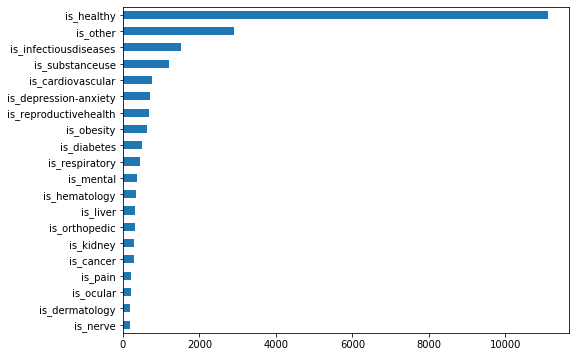

In [128]:
# What is the distribution of enrollment by condition type?
df_enrollment_distri = pd.DataFrame(all_distri).T
df_enrollment_distri['mean'].sort_values().plot.barh(figsize=(8, 6))
plt.show()

### Take away: when weigting by the numer enrolled, we should exclude "healthy" subjects

## Distribution of studies over time

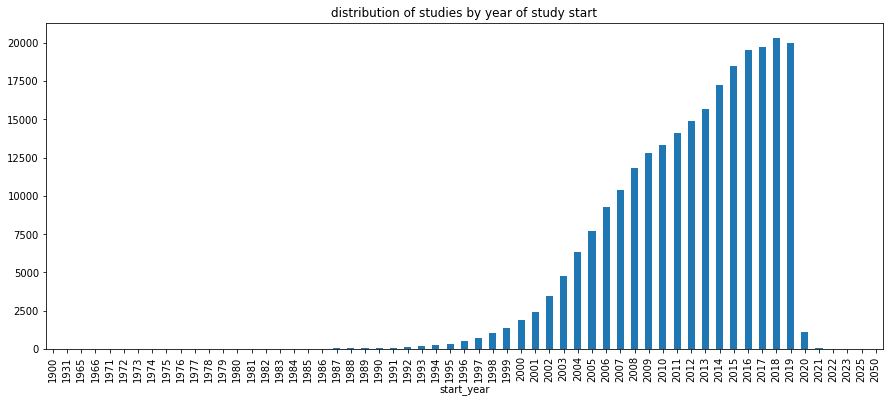

In [44]:
plt.figure(figsize=(15, 6))
df.groupby('start_year')['start_date'].count().plot.bar()
plt.title('distribution of studies by year of study start')
plt.show()

In [45]:
# making a column with the year buckets
df['start_year_bucket'] = df['start_year'].apply(lambda x: '1999-' if x < 2000
                                                 else ('2019+'
                                                       if x > 2019 
                                                       else str(x))
                                                 )

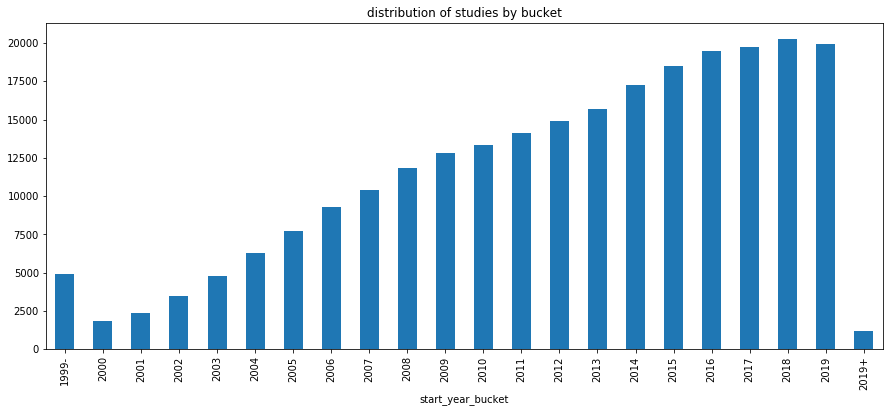

In [46]:
plt.figure(figsize=(15, 6))
df.groupby('start_year_bucket')['start_date'].count().plot.bar()
plt.title('distribution of studies by bucket')
plt.show()

### let's keep only those that started in 2000 -> 2009 inclusive

In [53]:
ex_date_buckets = ['1999-', '2019+']
dfm = df[~df['start_year_bucket'].isin(ex_date_buckets)]
dfm.shape

(244024, 52)

In [48]:
dfm.shape[0] / all_studies

0.7679893247394128

### We only keep studies in the 2000 - 2019 time frame, which is the majority of studies

![funnel2](img/funnel2.png)

## Finally, we should investigate the design_primary_purpose field to see if we need to filter anything else out

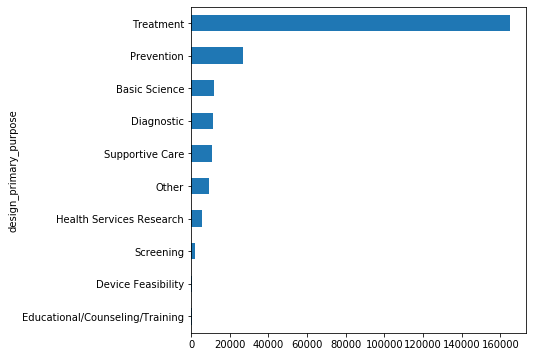

In [164]:
# most of the studies have the primary purpose = Treatment
df.groupby('design_primary_purpose').size().sort_values().plot.barh(figsize=(6,6))
plt.show()

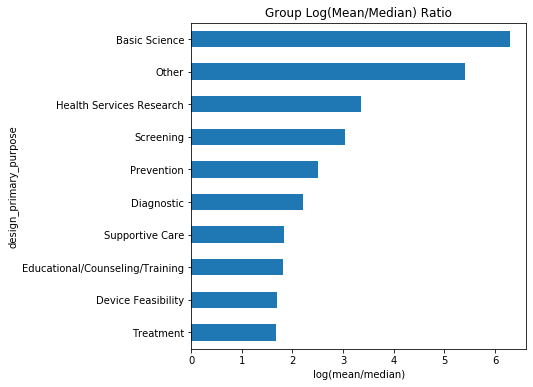

In [165]:
# Some of the enrollments of the non-treatment studies have very high skews 
# ie: a few studies on the right tail with a large number of enrolled
df_dpp = df.groupby('design_primary_purpose')['enrollment'].agg(['mean', 'median'])
df_dpp['skew'] = df_dpp['mean'] / df_dpp['median']
np.log(df_dpp['skew']).sort_values().plot.barh(figsize=(6,6))
plt.title('Group Log(Mean/Median) Ratio')
plt.xlabel("log(mean/median)")
plt.show()

### Take aways: Treatment design purposes covers most of the studies and does not have most of the skew problems that some of the other groups have. Let's just keep this one

In [167]:
dfmt = dfm[dfm['design_primary_purpose'] == 'Treatment']
dfmt.shape[0]

160246

In [168]:
dfmt.shape[0] / all_studies

0.5043242358628329

### After filtering by Design Purpose = Treatment, we have rought 50% of the studies remaining

![funnel3](img/funnel3.png)

### Plotting the number of studies as a portion of total studies over time (indexed to 2007)

In [169]:
all_buckets = sorted([x for x in df['start_year_bucket'].unique() if x not in ex_date_buckets])
all_buckets

['2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019']

In [170]:
# calculating % studies in each bucket
bucket_dict = {}
for cur_bucket in all_buckets:
    sub_df = dfmt[dfmt['start_year_bucket'] == cur_bucket]
    bucket_dict[cur_bucket] = sub_df[dummy_categories].sum() / sub_df.shape[0]
    
df_pcts = pd.DataFrame(bucket_dict)[sorted(bucket_dict.keys())]
df_pcts.reset_index()
df_pcts.index = df_pcts.reset_index()['index'].apply(lambda x: x[3:])
df_pcts

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
index,,,,,,,,,,,,,,,,,,,,
cancer,0.463303,0.378631,0.297716,0.267803,0.253823,0.244429,0.225995,0.218353,0.203234,0.195386,0.178938,0.170873,0.150828,0.144822,0.144206,0.159762,0.161431,0.161222,0.161375,0.169402
cardiovascular,0.054391,0.063797,0.063375,0.083585,0.081549,0.084162,0.078899,0.077728,0.078204,0.068743,0.072735,0.073965,0.069845,0.072860,0.071308,0.063363,0.063077,0.061696,0.058771,0.057311
depression-anxiety,0.019659,0.032158,0.034267,0.029420,0.036290,0.035139,0.029105,0.027410,0.024551,0.024567,0.024208,0.024473,0.024149,0.020034,0.023084,0.020975,0.023182,0.022850,0.022039,0.024818
dermatology,0.011796,0.008299,0.009580,0.011548,0.012232,0.013027,0.012983,0.013904,0.015329,0.016263,0.014949,0.013329,0.013220,0.015050,0.014673,0.017130,0.017470,0.015234,0.016652,0.014124
diabetes,0.026868,0.037863,0.049742,0.047842,0.045668,0.049709,0.052504,0.052834,0.051497,0.054671,0.049085,0.043920,0.045279,0.041563,0.044486,0.039241,0.035864,0.032498,0.030773,0.034778
healthy,0.025557,0.021266,0.026529,0.017047,0.017941,0.018855,0.027679,0.021054,0.026228,0.022376,0.022758,0.022069,0.020506,0.021529,0.023271,0.020975,0.016378,0.016588,0.015182,0.015267
hematology,0.013761,0.011929,0.018791,0.013198,0.016514,0.013198,0.011414,0.010064,0.012096,0.010496,0.010486,0.010707,0.009056,0.008073,0.009346,0.007516,0.008819,0.009648,0.008571,0.008246
infectiousdiseases,0.026868,0.033714,0.031319,0.028870,0.030377,0.033425,0.026823,0.024364,0.023114,0.023414,0.021531,0.018355,0.015405,0.017741,0.016449,0.020276,0.015538,0.012864,0.012489,0.015267
kidney,0.011140,0.010373,0.011422,0.013473,0.015087,0.017827,0.013126,0.012447,0.014251,0.013033,0.013498,0.012236,0.010721,0.011263,0.011402,0.011274,0.008399,0.009309,0.007346,0.008899


In [171]:
# excluding other
df_no_other = df_pcts.drop("other")
df_no_other = df_no_other / df_no_other.sum()

### Visualizing the percent of studies by category over time

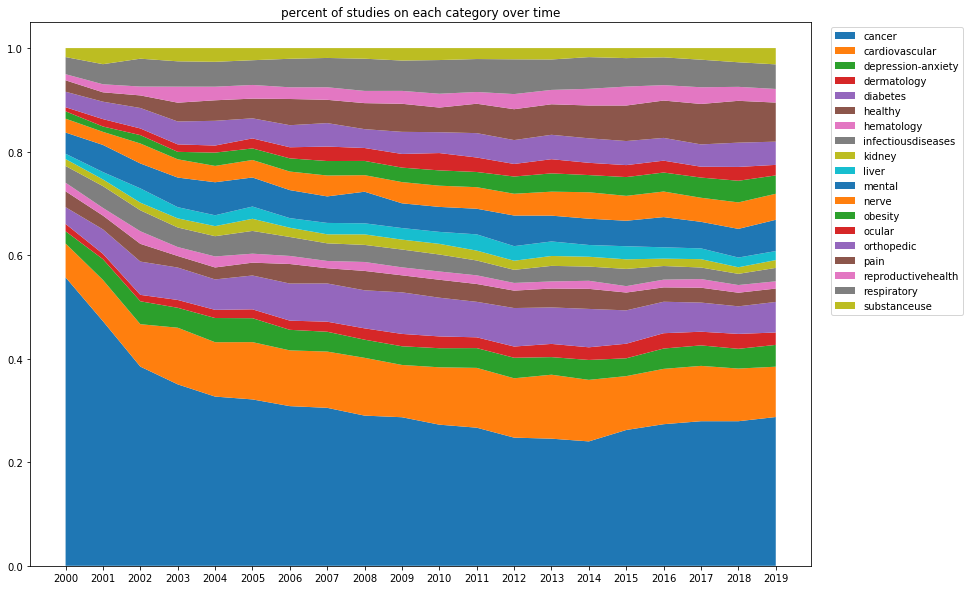

In [172]:
plt.figure(figsize=(14,10))
plt.stackplot(df_no_other.columns, 
              [df_no_other.loc[x].values for x in df_no_other.index], 
              labels=df_no_other.index)

plt.legend(bbox_to_anchor=(1.2,1))
plt.title('percent of studies on each category over time')
plt.show()

In [173]:
# indexing to 2007
df_indexed_2007 = df_no_other/ df_no_other['2007'][:, np.newaxis]

## Some studies have a bigger portion, while other have a smaller portion

This is hard to discern, subsequent charts will make this easier

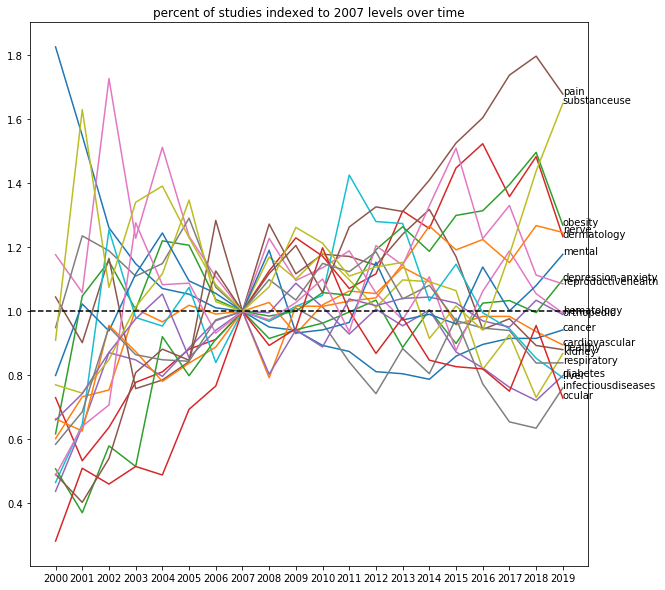

In [643]:
plt.figure(figsize=(10,10))
for idx in df_indexed_2007.index:
    plt.plot(df_indexed_2007.loc[idx].T, label=idx)
plt.title('percent of studies indexed to 2007 levels over time')
for idx in df_indexed_2007['2019'].index:
    plt.annotate(xy=[19, df_indexed_2007['2019'][idx]], s=idx)
plt.axhline(1., linestyle='--', color='k')
plt.show()

In [175]:
df_pct_change = df_indexed_2007['2019'] / df_indexed_2007['2007'] - 1 

### Just looking at 2019 levels / 2007 levels

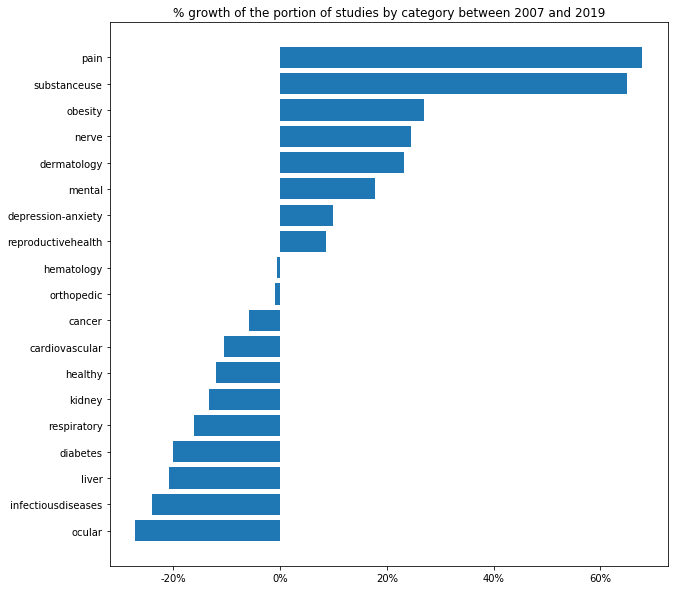

In [307]:
plt.figure(figsize=(10, 10))
plt.barh(df_pct_change.sort_values().index, df_pct_change.sort_values())
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.title("% growth of the portion of studies by category between 2007 and 2019")
plt.show()

## Same analysis by study count

In [436]:
# calculating % studies in each bucket
bucket_dict = {}
for cur_bucket in all_buckets:
    sub_df = dfmt[dfmt['start_year_bucket'] == cur_bucket]
    bucket_dict[cur_bucket] = sub_df[dummy_categories].sum() # / sub_df.shape[0]
    
df_pcts = pd.DataFrame(bucket_dict)[sorted(bucket_dict.keys())]
df_pcts.reset_index()
df_pcts.index = df_pcts.reset_index()['index'].apply(lambda x: x[3:])
df_pcts

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
index,,,,,,,,,,,,,,,,,,,,
cancer,707,730,808,974,1245,1426,1584,1649,1697,1694,1604,1564,1449,1453,1543,1828,1922,1905,1977,2075
cardiovascular,83,123,172,304,400,491,553,587,653,596,652,677,671,731,763,725,751,729,720,702
depression-anxiety,30,62,93,107,178,205,204,207,205,213,217,224,232,201,247,240,276,270,270,304
dermatology,18,16,26,42,60,76,91,105,128,141,134,122,127,151,157,196,208,180,204,173
diabetes,41,73,135,174,224,290,368,399,430,474,440,402,435,417,476,449,427,384,377,426
healthy,39,41,72,62,88,110,194,159,219,194,204,202,197,216,249,240,195,196,186,187
hematology,21,23,51,48,81,77,80,76,101,91,94,98,87,81,100,86,105,114,105,101
infectiousdiseases,41,65,85,105,149,195,188,184,193,203,193,168,148,178,176,232,185,152,153,187
kidney,17,20,31,49,74,104,92,94,119,113,121,112,103,113,122,129,100,110,90,109


### The story is a bit different if we just count the number of studies in the full year

Since 2019 incomplete, we use 2018 as the latest full year

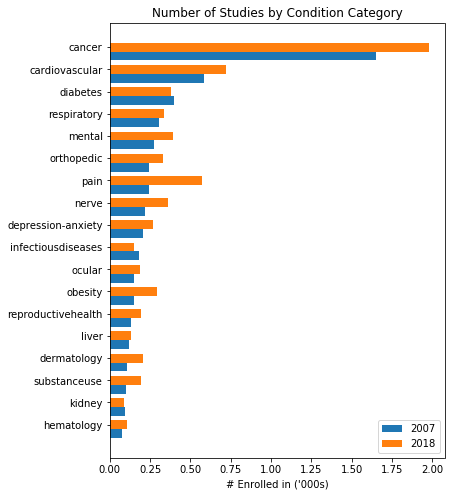

In [407]:
unit = 1000
plt.figure(figsize=(6,8))
s_2007 = df_pcts['2007'].drop(['healthy', 'other']).sort_values() / unit
s_2018 = df_pcts['2018'].drop(['healthy', 'other'])[s_2007.index ]/ unit
barwidth = 0.4
r1 = np.arange(len(s_2007))
r2 = [x + barwidth for x in r1]
plt.barh(r1, s_2007, height=barwidth, label='2007')
plt.barh(r2, s_2018, height=barwidth, label='2018')
plt.yticks([r + barwidth for r in range(len(s_2007))], s_2007.index)
plt.title('Number of Studies by Condition Category')
plt.xlabel("# Enrolled in ('%ss)" % str(unit)[1:])
plt.legend()
plt.show()

#### We'll come back to these growth rates to compare them with enrollment growth

In [410]:
# compute the growth rates for use later
s_pct_change_count = (df_pcts['2018'] / df_pcts['2007'] - 1).dropna()
s_pct_change_count

index
cancer                0.198908
cardiovascular        0.226576
depression-anxiety    0.304348
dermatology           0.942857
diabetes             -0.055138
healthy               0.169811
hematology            0.381579
infectiousdiseases   -0.168478
kidney               -0.042553
liver                 0.117647
mental                0.415162
nerve                 0.660550
obesity               0.960265
ocular                0.251656
orthopedic            0.355102
other                 1.297217
pain                  1.353909
reproductivehealth    0.458015
respiratory           0.098039
substanceuse          0.883495
dtype: float64

## Same analysis weighted by enrollment

In [194]:
dfmt.groupby('enrollment_type').size()

enrollment_type
Actual         98345
Anticipated    55530
dtype: int64

In [197]:
dfmt_by_enrollment = dfmt[(dfmt['is_healthy'] == 0) & 
                          (pd.notnull(dfmt['enrollment']))].copy()

In [230]:
dfmt_by_enrollment.shape[0], dfmt_by_enrollment.shape[0] / all_studies

(155579, 0.4896363109924971)

## To look at the data by "enrollment count" we need to filter a few more out

- Healthy studies tend to have very large enrollment counts
- we also exclude studies that do not have any enrollment listed (null)

![funnel4](img/funnel4.png)

### Some fo the data is bad, so we should look at medians instead of means

In [198]:
# that first entry clearly looks wrong, looks like this was a date 12/12/2012 entered as a enrollment field
dfmt_by_enrollment['enrollment'].sort_values(ascending=False)

nct_id
NCT02361008    20121212.0
NCT03014167      380000.0
NCT03335072      320000.0
NCT01152918      299038.0
NCT02914145      240502.0
                  ...    
NCT01666236           0.0
NCT03343977           0.0
NCT03343847           0.0
NCT03343678           0.0
NCT03502135           0.0
Name: enrollment, Length: 155579, dtype: float64

### Let's see the distribution of enrollments by enrollment_type

In [203]:
dfmt_by_enrollment['enrollment_type'].unique()

array(['Actual', 'Anticipated', None], dtype=object)

In [205]:
dfmt_by_enrollment.shape

(155579, 52)

### The distribtion of enrollment counts tapers off at 8

so we clip the number at 5000 ~= exp(8.5)

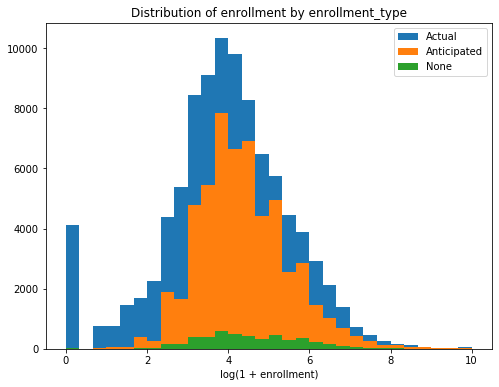

In [217]:
plt.figure(figsize=(8, 6))
for et in dfmt_by_enrollment['enrollment_type'].unique():
    if et is None:
        sub_df = dfmt_by_enrollment[pd.isnull(dfmt_by_enrollment['enrollment_type'])]
        label = 'None'
    else:
        sub_df = dfmt_by_enrollment[dfmt_by_enrollment['enrollment_type'] == et]
        label = et
    plt.hist(np.log1p(sub_df['enrollment']).clip(0, 10), bins=30, label=label)
plt.legend()
plt.title('Distribution of enrollment by enrollment_type')
plt.xlabel('log(1 + enrollment)')
plt.show()

#### We can clip the number of enrolled to 5000k, since the tail is pretty long beyond here

In [231]:
dfmt_by_enrollment['enrollment_clipped'] = dfmt_by_enrollment['enrollment'].clip(0, 5000)

## How has the size of enrollment changed over time?

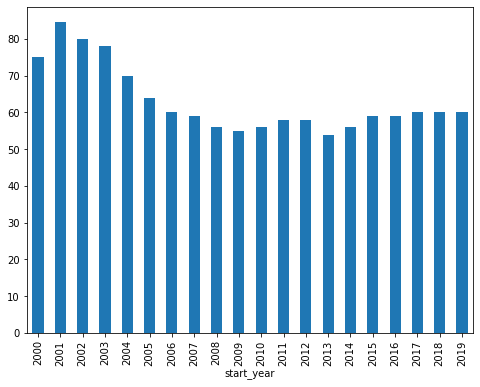

In [235]:
dfmt_by_enrollment.groupby('start_year')['enrollment_clipped'].median().plot.bar(figsize=(8, 6))
plt.show()

In [241]:
(dfmt_by_enrollment[dummy_categories]['is_cancer'] * dfmt_by_enrollment['enrollment_clipped']).sum()

3651873.0

### Tallying up the studies by total enrollment

In [434]:
# calculating % studies in each bucket
bucket_dict = {}
for cur_bucket in all_buckets:
    sub_df = dfmt_by_enrollment[dfmt_by_enrollment['start_year_bucket'] == cur_bucket]
    cur_total_enrolled = sub_df['enrollment_clipped'].sum()
    
    cur_cat_counts = {}
    for cur_cat in dummy_categories:
        num_enrolled = sub_df[sub_df[cur_cat] == 1]['enrollment_clipped'].sum()
        cur_cat_counts[cur_cat] = num_enrolled # / cur_total_enrolled
        
    bucket_dict[cur_bucket] = cur_cat_counts
    

In [435]:
df_pcts_enrollment = pd.DataFrame(bucket_dict)[sorted(bucket_dict.keys())]
df_pcts_enrollment.reset_index()
df_pcts_enrollment.index = df_pcts_enrollment.reset_index()['index'].apply(lambda x: x[3:])
df_pcts_enrollment

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
index,,,,,,,,,,,,,,,,,,,,
cancer,72174.0,115171.0,113256.0,133242.0,179982.0,178714.0,208258.0,184480.0,192394.0,177228.0,179768.0,183028.0,164940.0,161926.0,176260.0,265824.0,238699.0,215178.0,248100.0,263251.0
cardiovascular,34801.0,69138.0,87603.0,143253.0,158434.0,151078.0,218368.0,157427.0,230911.0,180718.0,187077.0,163460.0,179897.0,199367.0,176378.0,148843.0,182225.0,199450.0,236916.0,238934.0
depression-anxiety,4932.0,15119.0,12423.0,21361.0,39153.0,34703.0,40437.0,29506.0,34171.0,33465.0,42288.0,53396.0,35587.0,36764.0,44504.0,36833.0,36223.0,45436.0,60518.0,45243.0
dermatology,1894.0,2116.0,5804.0,9364.0,16998.0,13657.0,16014.0,12795.0,22844.0,17929.0,22123.0,24253.0,26386.0,29820.0,29318.0,50908.0,37763.0,32562.0,50688.0,33219.0
diabetes,21443.0,36198.0,28538.0,50189.0,65326.0,74797.0,76547.0,69555.0,96128.0,95994.0,120537.0,79605.0,93246.0,98074.0,82950.0,73282.0,67139.0,72063.0,83158.0,92132.0
healthy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hematology,3301.0,1734.0,9060.0,7183.0,24362.0,13241.0,12286.0,18652.0,10505.0,13534.0,15924.0,9998.0,8884.0,10515.0,17204.0,9468.0,24444.0,22571.0,24775.0,21517.0
infectiousdiseases,14071.0,19099.0,16566.0,32657.0,46564.0,43347.0,42462.0,39352.0,34542.0,43628.0,51748.0,35141.0,28038.0,49626.0,46057.0,51052.0,57628.0,38021.0,40088.0,48080.0
kidney,3154.0,9566.0,12089.0,10159.0,17683.0,16388.0,13734.0,15318.0,19286.0,12967.0,13070.0,14810.0,13413.0,20873.0,15202.0,26749.0,18329.0,15977.0,13196.0,27393.0


### If we compare 2018 to 2007 via the number of "enrolled" the results are different 

As opposed to count of studies

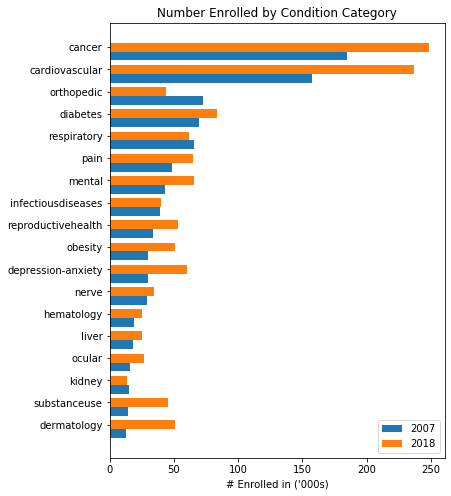

In [292]:
unit = 1000
plt.figure(figsize=(6,8))
s_2007 = df_pcts['2007'].drop(['healthy', 'other']).sort_values() / unit
s_2018 = df_pcts['2018'].drop(['healthy', 'other'])[s_2007.index ]/ unit
barwidth = 0.4
r1 = np.arange(len(s_2007))
r2 = [x + barwidth for x in r1]
plt.barh(r1, s_2007, height=barwidth, label='2007')
plt.barh(r2, s_2018, height=barwidth, label='2018')
plt.yticks([r + barwidth for r in range(len(s_2007))], s_2007.index)
plt.title('Number Enrolled by Condition Category')
plt.xlabel("# Enrolled in ('%ss)" % str(unit)[1:])
plt.legend()
plt.show()

In [305]:
s_pct_change_enrollment = (df_pcts['2018'] / df_pcts['2007'] - 1).dropna()

In [314]:
s_pct_change_enrollment

index
cancer                0.344861
cardiovascular        0.504926
depression-anxiety    1.051040
dermatology           2.961547
diabetes              0.195572
hematology            0.328276
infectiousdiseases    0.018703
kidney               -0.138530
liver                 0.348022
mental                0.505317
nerve                 0.200458
obesity               0.702378
ocular                0.640447
orthopedic           -0.399438
other                 1.193074
pain                  0.329659
reproductivehealth    0.598988
respiratory          -0.060607
substanceuse          2.161806
dtype: float64

In [323]:
df_changes = pd.DataFrame([s_pct_change_count, s_pct_change_enrollment], index=['bycount', 
                                                                                'byenrollment']).T.dropna()

## We can compare how the count vs enrollment methods are different

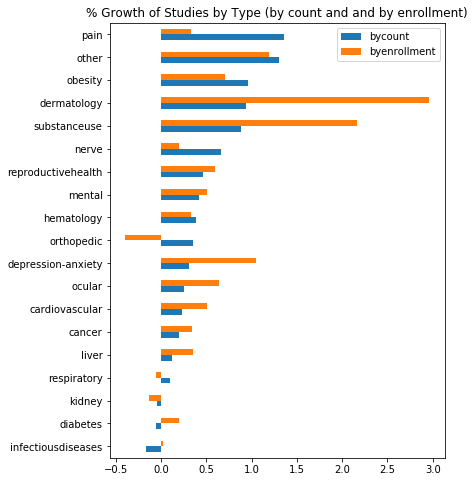

In [329]:
df_changes.sort_values('bycount').plot.barh(figsize=(6, 8))
plt.title('% Growth of Studies by Type (by count and and by enrollment)')
plt.show()

### Take aways:
- The big categories such as cancer and cardiovascular do have more growth in enrollment as compared to study count
- Pain study's growth is on smaller studies
- Studies are getting much larger in dermatoloty, substance usage and depression-anxiety

## By Region

In [375]:
dfmt.columns

Index(['start_date', 'start_date_type', 'enrollment_type', 'verification_date',
       'phase', 'number_of_arms', 'source', 'cond_categories', 'start_year',
       'sponsor_agency_class', 'sponsor_name', 'countries', 'is_orphan',
       'conditions', 'closest_orphan', 'enrollment', 'last_known_status',
       'brief_title', 'overall_status', 'official_title',
       'primary_completion_date', 'primary_completion_date_type',
       'browse_conditions', 'browse_interventions', 'description', 'is_us',
       'is_cancer', 'is_other', 'is_cardiovascular', 'is_diabetes',
       'is_mental', 'is_infectiousdiseases', 'is_respiratory', 'is_pain',
       'is_healthy', 'is_obesity', 'is_depression-anxiety', 'is_orthopedic',
       'is_nerve', 'is_reproductivehealth', 'is_substanceuse', 'is_ocular',
       'is_liver', 'is_kidney', 'is_dermatology', 'is_hematology',
       'sponsor_collaborators', 'design_allocation',
       'design_intervention_model', 'design_masking', 'design_primary_purpose',
 

In [386]:
all_countries = Counter()
for val in tqdm(dfmt['countries'].values):
    for country in val:
        all_countries[country] += 1

In [395]:
dfc_counts = pd.DataFrame(all_countries.most_common(20), columns=['country', 'count']).set_index('country')

## Unsuprisingly, US is the most prevelent country in the dataset

We will for some subsequent analysis look at "US-only" data

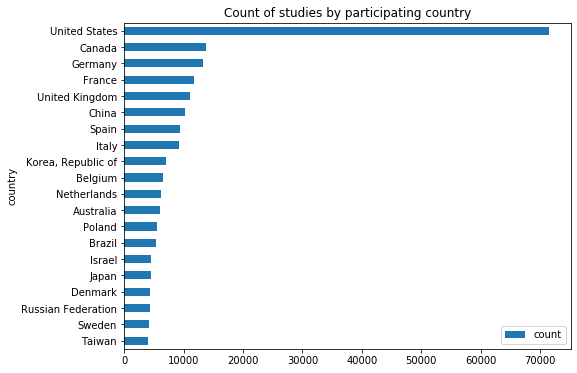

In [399]:
dfc_counts.sort_values('count', ascending=True).plot.barh(figsize=(8, 6))
plt.title("Count of studies by participating country")
plt.show()

### Narrowing to just US studies, how have to distribution of studies changed?

In [401]:
df_us = dfmt[dfmt['is_us'] == 1]

In [433]:
# calculating % studies in each bucket
bucket_dict = {}
for cur_bucket in all_buckets:
    sub_df = df_us[df_us['start_year_bucket'] == cur_bucket]
    bucket_dict[cur_bucket] = sub_df[dummy_categories].sum() # / sub_df.shape[0]
    
df_pcts_us = pd.DataFrame(bucket_dict)[sorted(bucket_dict.keys())]
df_pcts_us.reset_index()
df_pcts_us.index = df_pcts_us.reset_index()['index'].apply(lambda x: x[3:])
df_pcts_us

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
index,,,,,,,,,,,,,,,,,,,,
cancer,550,537,589,675,890,984,1038,1059,995,1008,959,921,833,796,825,943,962,1001,962,917
cardiovascular,35,54,81,142,166,205,237,233,262,232,224,197,233,226,194,194,212,235,223,180
depression-anxiety,24,46,67,78,132,130,143,125,124,126,140,130,127,113,118,124,130,144,133,136
dermatology,13,10,13,23,25,38,46,61,68,87,76,55,69,72,92,116,119,115,119,90
diabetes,27,30,59,73,113,147,183,191,210,230,190,166,177,181,182,155,148,156,141,139
healthy,10,11,17,14,23,36,53,59,72,65,71,62,47,66,80,67,60,69,60,50
hematology,13,14,25,25,42,52,38,39,49,47,51,51,50,37,45,42,48,57,58,36
infectiousdiseases,35,42,59,47,82,104,94,92,85,89,89,74,62,70,75,108,77,58,53,75
kidney,7,10,15,31,28,43,40,40,58,43,47,46,38,49,44,52,36,47,39,52


### Looking at counts of studies in the US-only set, the story is again different

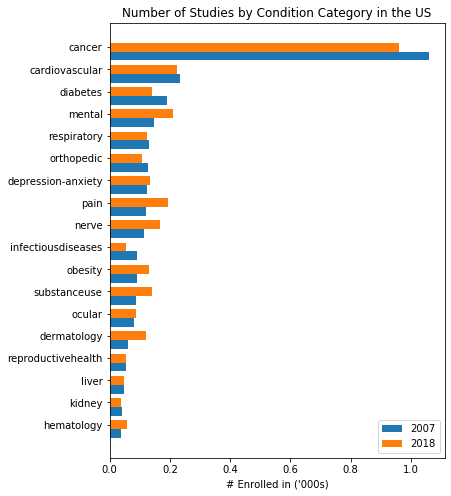

In [409]:
unit = 1000
plt.figure(figsize=(6,8))
s_2007 = df_pcts_us['2007'].drop(['healthy', 'other']).sort_values() / unit
s_2018 = df_pcts_us['2018'].drop(['healthy', 'other'])[s_2007.index ]/ unit
barwidth = 0.4
r1 = np.arange(len(s_2007))
r2 = [x + barwidth for x in r1]
plt.barh(r1, s_2007, height=barwidth, label='2007')
plt.barh(r2, s_2018, height=barwidth, label='2018')
plt.yticks([r + barwidth for r in range(len(s_2007))], s_2007.index)
plt.title('Number of Studies by Condition Category in the US')
plt.xlabel("# Enrolled in ('%ss)" % str(unit)[1:])
plt.legend()
plt.show()

In [411]:
# compute the growth rates for use later
s_pct_change_count_us = (df_pcts_us['2018'] / df_pcts_us['2007'] - 1).dropna()
s_pct_change_count_us

index
cancer               -0.091596
cardiovascular       -0.042918
depression-anxiety    0.064000
dermatology           0.950820
diabetes             -0.261780
healthy               0.016949
hematology            0.487179
infectiousdiseases   -0.423913
kidney               -0.025000
liver                -0.020833
mental                0.421769
nerve                 0.469027
obesity               0.433333
ocular                0.048780
orthopedic           -0.142857
other                 0.742345
pain                  0.608333
reproductivehealth    0.037736
respiratory          -0.046154
substanceuse          0.597701
dtype: float64

In [421]:
df_pct_change_us = pd.DataFrame([s_pct_change_count, s_pct_change_count_us], index=['global', 'us']).T

## We can compare the US growth rates vs global growth rates

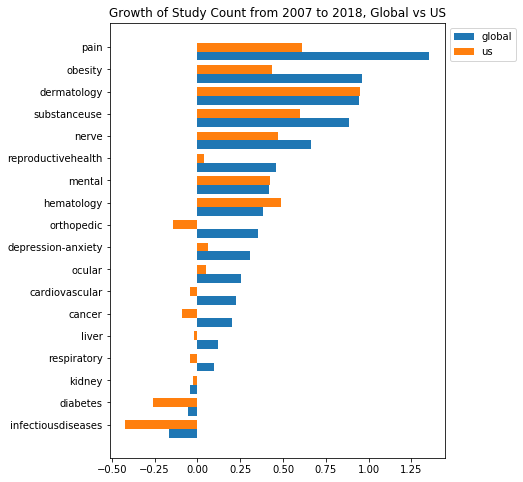

In [425]:
plt.figure(figsize=(6,8))
s_global = df_pct_change_us['global'].drop(['healthy', 'other']).sort_values()
s_us = df_pct_change_us['us'].drop(['healthy', 'other'])[s_global.index]
barwidth = 0.4
r1 = np.arange(len(s_global))
r2 = [x + barwidth for x in r1]
plt.barh(r1, s_global, height=barwidth, label='global')
plt.barh(r2, s_us, height=barwidth, label='us')
plt.yticks([r + barwidth for r in range(len(s_global))], s_global.index)
plt.title('Growth of Study Count from 2007 to 2018, Global vs US')
plt.legend(bbox_to_anchor=(1., 1.))
plt.show()

## Take aways:
- Studies growth rates on most studies has increased more from outside the US than within
    - This could be just a measurement bias where more studies outside of the US are getting record
- The number of studies in the US on cancer actally decreased between 2007 and 2018

### US by enrollment

In [562]:
dfmt_us_enrollment = dfmt_by_enrollment[dfmt_by_enrollment['is_us'] == 1].copy()

In [430]:
# calculating % studies in each bucket
bucket_dict = {}
for cur_bucket in all_buckets:
    sub_df = dfmt_us_enrollment[dfmt_us_enrollment['start_year_bucket'] == cur_bucket]
    cur_total_enrolled = sub_df['enrollment_clipped'].sum()
    
    cur_cat_counts = {}
    for cur_cat in dummy_categories:
        num_enrolled = sub_df[sub_df[cur_cat] == 1]['enrollment_clipped'].sum()
        cur_cat_counts[cur_cat] = num_enrolled # / cur_total_enrolled
        
    bucket_dict[cur_bucket] = cur_cat_counts

In [432]:
df_pcts_us_enrollment = pd.DataFrame(bucket_dict)[sorted(bucket_dict.keys())]
df_pcts_us_enrollment.reset_index()
df_pcts_us_enrollment.index = df_pcts_us_enrollment.reset_index()['index'].apply(lambda x: x[3:])
df_pcts_us_enrollment

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
index,,,,,,,,,,,,,,,,,,,,
cancer,35339.0,53867.0,54228.0,82827.0,93828.0,95525.0,100490.0,90401.0,90569.0,89445.0,101348.0,100644.0,73865.0,81962.0,86537.0,114759.0,111167.0,109159.0,113935.0,101761.0
cardiovascular,9074.0,37528.0,40767.0,74188.0,90310.0,75354.0,109806.0,52431.0,116155.0,83393.0,81722.0,52561.0,61848.0,69389.0,48669.0,41216.0,61892.0,68241.0,74050.0,44003.0
depression-anxiety,4064.0,12029.0,10060.0,16198.0,30214.0,24582.0,27044.0,13572.0,22378.0,21542.0,26637.0,39305.0,20476.0,16576.0,24911.0,16169.0,18935.0,25937.0,31706.0,25564.0
dermatology,1615.0,1181.0,3132.0,4500.0,7772.0,5866.0,9728.0,8351.0,14054.0,10796.0,16111.0,14977.0,19811.0,20782.0,23089.0,32067.0,30778.0,26750.0,39151.0,20147.0
diabetes,14909.0,11307.0,10856.0,21825.0,44810.0,46724.0,48012.0,42255.0,58903.0,60360.0,80671.0,40045.0,45152.0,71568.0,46487.0,33343.0,35444.0,34528.0,36380.0,39479.0
healthy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hematology,533.0,558.0,2715.0,3490.0,13610.0,8604.0,5236.0,8094.0,4629.0,5927.0,5576.0,3331.0,5577.0,5179.0,10183.0,4713.0,16587.0,11521.0,10164.0,5436.0
infectiousdiseases,13498.0,9017.0,8806.0,12004.0,18555.0,19248.0,20684.0,13421.0,12998.0,12966.0,21432.0,12554.0,12163.0,12648.0,16372.0,23583.0,15637.0,10740.0,11568.0,13279.0
kidney,974.0,8334.0,6829.0,6623.0,9431.0,8540.0,8434.0,8785.0,6640.0,4317.0,4435.0,5939.0,4436.0,13646.0,5451.0,17194.0,7931.0,7819.0,5441.0,16576.0


In [437]:
s_pct_change_enrollment_us = (df_pcts_us_enrollment['2018'] / df_pcts_us_enrollment['2007'] - 1).dropna()

In [442]:
df_enrollment_us = pd.DataFrame([s_pct_change_enrollment, s_pct_change_enrollment_us], index=['global', 'us']).T
df_enrollment_us

,global,us
index,,
cancer,0.344861,0.260329
cardiovascular,0.504926,0.412332
depression-anxiety,1.051040,1.336133
dermatology,2.961547,3.688181
diabetes,0.195572,-0.139037
hematology,0.328276,0.255745
infectiousdiseases,0.018703,-0.138067
kidney,-0.138530,-0.380649
liver,0.348022,-0.085168


## Finally, if we do the same analysis by enrollment numbers, we get the following

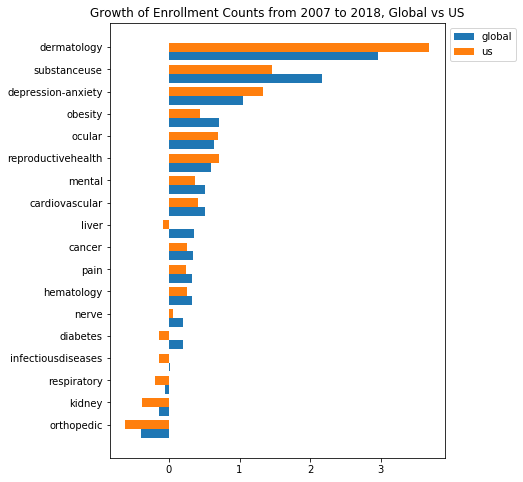

In [444]:
plt.figure(figsize=(6,8))
s_global = df_enrollment_us['global'].drop(['other']).sort_values()
s_us = df_enrollment_us['us'].drop(['other'])[s_global.index]
barwidth = 0.4
r1 = np.arange(len(s_global))
r2 = [x + barwidth for x in r1]
plt.barh(r1, s_global, height=barwidth, label='global')
plt.barh(r2, s_us, height=barwidth, label='us')
plt.yticks([r + barwidth for r in range(len(s_global))], s_global.index)
plt.title('Growth of Enrollment Counts from 2007 to 2018, Global vs US')
plt.legend(bbox_to_anchor=(1., 1.))
plt.show()

### Takeaways:
- Enrollment counts for diabetes is down in the US
- While the previous chart showed that study counts for cancer is down in the US, enrollment is actually up
- Enrollment in US dermatology is up dramatically
- enrollment in US for depression and anxiety is up more than the rest of the world despite the previously discussed bias that global studies are getting recorded more in 2018 than in 2007

## By Sponsor (Focusing on the US)

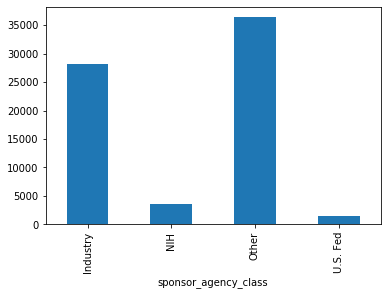

In [469]:
dfmt_us_enrollment.groupby('sponsor_agency_class').size().plot.bar()
plt.show()

#### What are the top sponsors in Industry and in other?

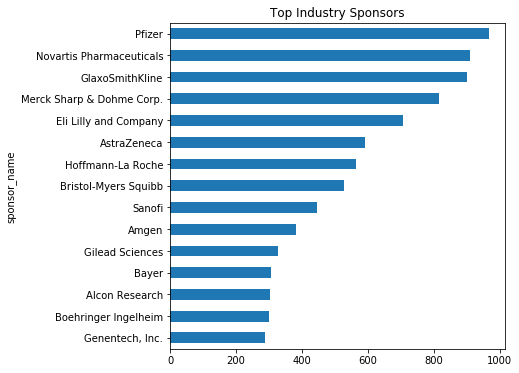

In [473]:
df_ind = dfmt_us_enrollment[dfmt_us_enrollment['sponsor_agency_class'] == 'Industry']
df_ind.groupby('sponsor_name').size().sort_values(ascending=True)[-15:].plot.barh(figsize=(6, 6)) 
plt.title('Top Industry Sponsors')
plt.show()

#### This looks like "Big Pharma"

#### What about "Other" sponsors?

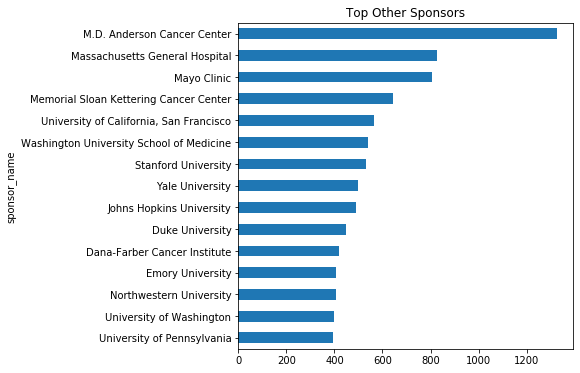

In [532]:
df_oth = dfmt_us_enrollment[dfmt_us_enrollment['sponsor_agency_class'] == 'Other']
df_oth.groupby('sponsor_name').size().sort_values(ascending=True)[-15:].plot.barh(figsize=(6, 6)) 
plt.title('Top Other Sponsors')
plt.show()

### How have the study counts by sponsors changed over time?

In [522]:
df_sponsor_enrolled_ind = df_ind.groupby(['start_year', 
                            'sponsor_name']).size().reset_index().pivot(index='sponsor_name',
                                                                        columns='start_year').fillna(0)
df_sponsor_enrolled_ind.columns = df_sponsor_enrolled_ind.columns.droplevel(0)

In [523]:
top10_ind = df_sponsor_enrolled_ind.sum(axis=1).sort_values(ascending=False)[:10].index

### The study counts by "Industry" sponsors looked to have peaked around 2008

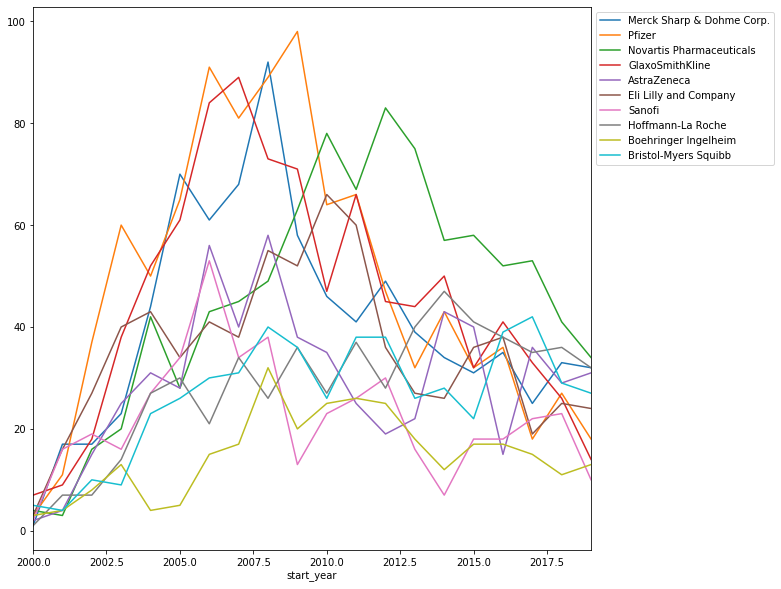

In [529]:
df_sponsor_enrolled_ind.loc[top20_ind].T.plot(figsize=(10, 10))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### other sponsors

In [533]:
df_sponsor_enrolled_oth = df_oth.groupby(['start_year', 
                            'sponsor_name']).size().reset_index().pivot(index='sponsor_name',
                                                                        columns='start_year').fillna(0)
df_sponsor_enrolled_oth.columns = df_sponsor_enrolled_oth.columns.droplevel(0)

In [534]:
top10_oth = df_sponsor_enrolled_oth.sum(axis=1).sort_values(ascending=False)[:10].index

## On the other hand, other sponsors have kept growing

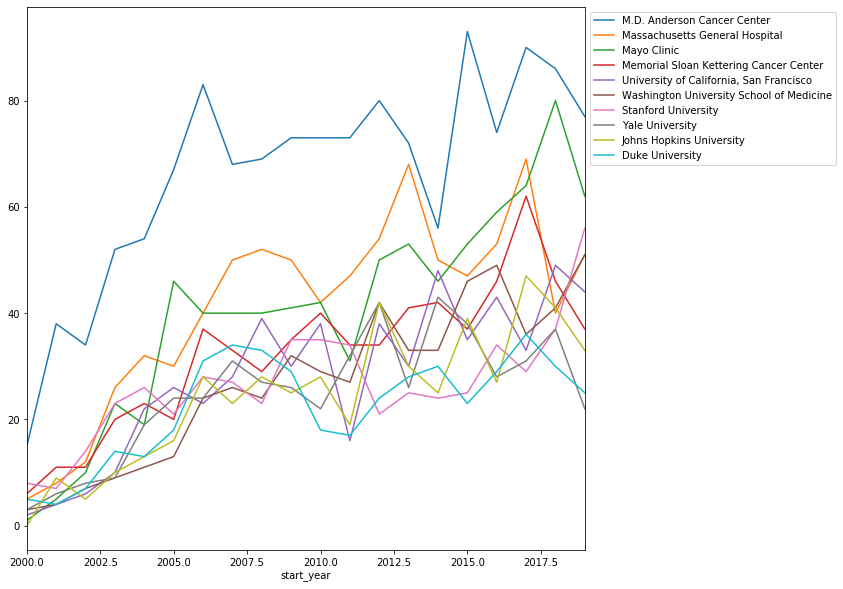

In [535]:
df_sponsor_enrolled_oth.loc[top10_oth].T.plot(figsize=(10, 10))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Comparing the 2 we can see the pattern that non-profits are growing in their share of research as compared to "big pharma" (US)

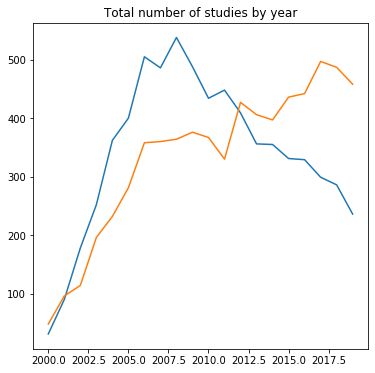

In [539]:
plt.figure(figsize=(6,6))
plt.plot(df_sponsor_enrolled_ind.loc[top10_ind].T.sum(axis=1), label='Industry')
plt.plot(df_sponsor_enrolled_oth.loc[top10_oth].T.sum(axis=1), label='Non-Profit/University')
plt.title('Total number of studies by year')
plt.show()

## By Phase

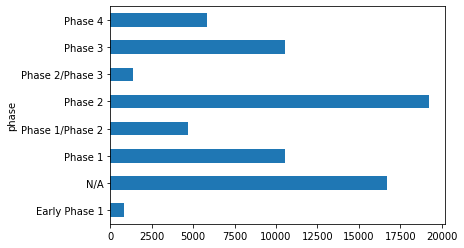

In [544]:
dfmt_us_enrollment.groupby('phase').size().plot.barh()
plt.show()

In [564]:
dfmt_us_enrollment['is_phase1'] = dfmt_us_enrollment['phase'].apply(lambda x: 1 if 'Phase 1' in x else 0)
dfmt_us_enrollment['is_phase2'] = dfmt_us_enrollment['phase'].apply(lambda x: 1 if 'Phase 2' in x else 0)
dfmt_us_enrollment['is_phase3'] = dfmt_us_enrollment['phase'].apply(lambda x: 1 if 'Phase 3' in x else 0)
dfmt_us_enrollment['is_phase4'] = dfmt_us_enrollment['phase'].apply(lambda x: 1 if 'Phase 4' in x else 0)

In [609]:
dfmt_by_enrollment['is_phase1'] = dfmt_by_enrollment['phase'].apply(lambda x: 1 if 'Phase 1' in x else 0)
dfmt_by_enrollment['is_phase2'] = dfmt_by_enrollment['phase'].apply(lambda x: 1 if 'Phase 2' in x else 0)
dfmt_by_enrollment['is_phase3'] = dfmt_by_enrollment['phase'].apply(lambda x: 1 if 'Phase 3' in x else 0)
dfmt_by_enrollment['is_phase4'] = dfmt_by_enrollment['phase'].apply(lambda x: 1 if 'Phase 4' in x else 0)

## Phases
- Phase 1 - Is the treatment safe?
- Phase 2 - Does the treatment work?
- Phase 3 - Is it better than what is already available?
- Phase 4 - What else do we need to know?

### How have the phases progressed over time?

In [570]:
phase_cols = ['is_phase' + str(x) for x in range(1, 5)]
phase_cols

['is_phase1', 'is_phase2', 'is_phase3', 'is_phase4']

In [ ]:
def phase_groups_s(df):
    return df[phase_cols].sum() / df[phase_cols].sum().sum()

## all regions 

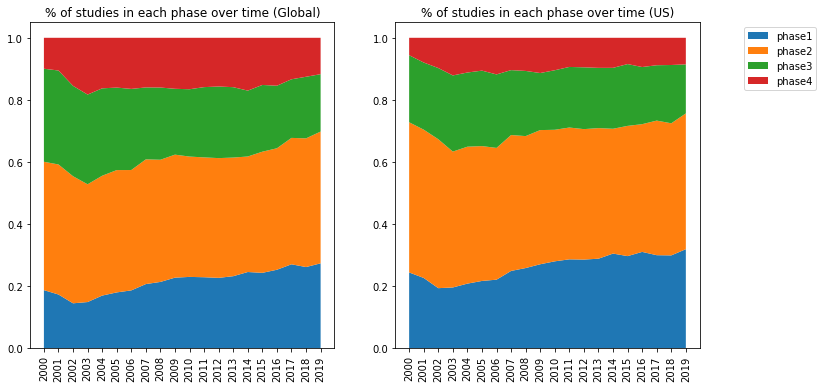

In [622]:
cur_phases = dfmt_by_enrollment.groupby(['start_year']).apply(phase_groups_s).T
cur_phases.index = [x[3:] for x in cur_phases.index]
cur_phases_us = dfmt_us_enrollment.groupby(['start_year']).apply(phase_groups_s).T
cur_phases_us.index = [x[3:] for x in cur_phases_us.index]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.stackplot(cur_phases.columns.astype(str), 
              [cur_phases.loc[x].values for x in cur_phases.index], 
              labels=cur_phases.index)
ax1.set_title('% of studies in each phase over time (Global)')
ax1.set_xticklabels(cur_phases.columns.astype(str), rotation=90)
ax2.stackplot(cur_phases_us.columns.astype(str), 
              [cur_phases_us.loc[x].values for x in cur_phases_us.index], 
              labels=cur_phases_us.index)
ax2.set_title('% of studies in each phase over time (US)')
ax2.set_xticklabels(cur_phases_us.columns.astype(str), rotation=90)
plt.legend(bbox_to_anchor=(1.4,1))
plt.show()

## Takeaways:
- Seems like more phase 4 studies outside of the US
- Phase 1 studies have taken more share at the exponse of phase 3 and 4

### By Disease Category

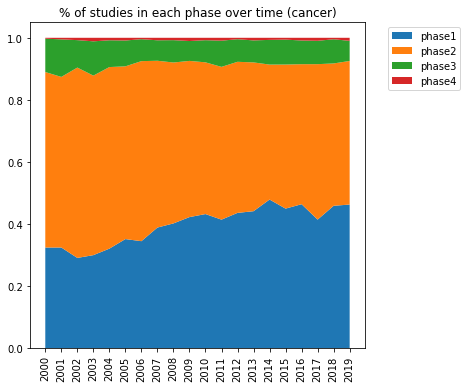

In [628]:
cur_cat = 'is_cancer'

sub_df = dfmt_us_enrollment[dfmt_us_enrollment[cur_cat] == 1]
cur_phases = sub_df.groupby(['start_year']).apply(phase_groups_s).T
cur_phases.index = [x[3:] for x in cur_phases.index]

plt.figure(figsize=(6,6))
plt.stackplot(cur_phases.columns.astype(str), 
              [cur_phases.loc[x].values for x in cur_phases.index], 
              labels=cur_phases.index)

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.3,1))
plt.title('%% of studies in each phase over time (%s)' % cur_cat[3:])
plt.show()

In [635]:
len(dummy_categories)

20

## Appendix with all disease types in various phases over time

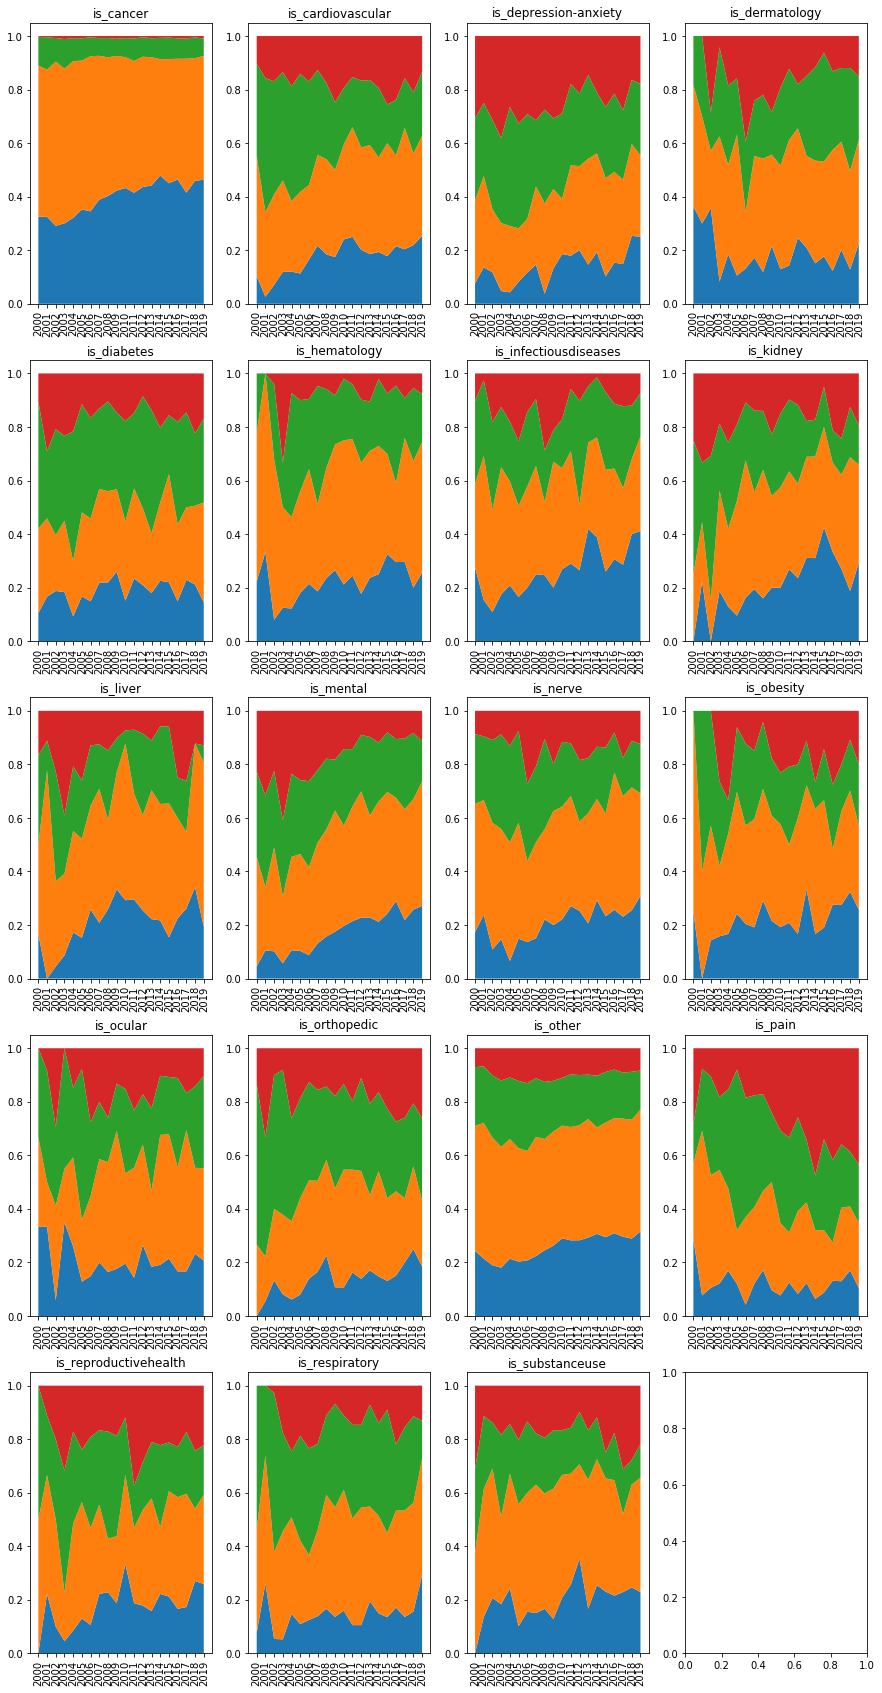

In [641]:
fig, axes = plt.subplots(5, 4, figsize=(15, 30))
i = 0
for cur_cat in dummy_categories:
    sub_df = dfmt_us_enrollment[dfmt_us_enrollment[cur_cat] == 1]
    if sub_df.shape[0] > 0:
        j = i // 4
        k = i % 4
        cur_phases = sub_df.groupby(['start_year']).apply(phase_groups_s).T
        cur_phases.index = [x[3:] for x in cur_phases.index]
        axes[j, k].stackplot(cur_phases.columns.astype(str), 
              [cur_phases.loc[x].values for x in cur_phases.index], 
              labels=cur_phases.index)
        axes[j, k].set_title(cur_cat)
        axes[j, k].set_xticklabels(cur_phases.columns.astype(str), rotation=90)
        i += 1
plt.show()

## Take aways:
- Pain studies in phase 4 have steadily grown
- Cancer research is almost never phase 4
- Many categories have seen growth in phase 1 studies

## Orphan Disease

In [647]:
dfmt_us_enrollment.groupby('is_orphan').size() / dfmt_us_enrollment.groupby('is_orphan').size().sum()

is_orphan
False    0.792464
True     0.207536
dtype: float64

### in the US, looks like 21% of studies are on orpha diseases:

## This ratio has been range bound between 18% and 26%

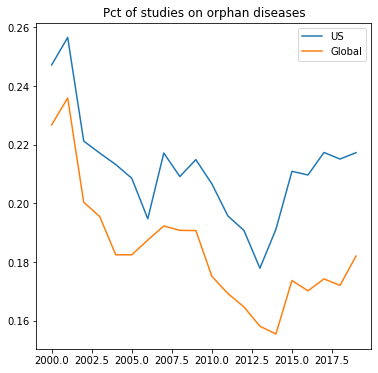

In [554]:
df_us_orphan = dfmt_us_enrollment[dfmt_us_enrollment['is_orphan']]
df_orphan = dfmt_by_enrollment[dfmt_by_enrollment['is_orphan']]
s_pct_orphan_us = df_us_orphan.groupby('start_year').size() / dfmt_us_enrollment.groupby('start_year').size()
s_pct_orphan = df_orphan.groupby('start_year').size() / dfmt_by_enrollment.groupby('start_year').size()
plt.figure(figsize=(6, 6))
plt.plot(s_pct_orphan_us, label='US')
plt.plot(s_pct_orphan, label='Global')
plt.title('Pct of studies on orphan diseases')
plt.legend()
plt.show()

#### Global research on Orphan diseases lag US

### Orphan disease enrollment counts

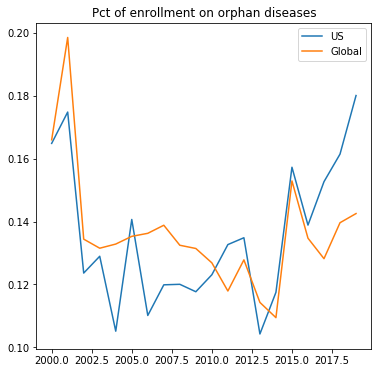

In [560]:
s_enroll_orphan_us = df_us_orphan.groupby('start_year')['enrollment_clipped'].sum() / \
                     dfmt_us_enrollment.groupby('start_year')['enrollment_clipped'].sum()
s_enroll_orphan = df_orphan.groupby('start_year')['enrollment_clipped'].sum() / \
                  dfmt_by_enrollment.groupby('start_year')['enrollment_clipped'].sum()

plt.figure(figsize=(6, 6))
plt.plot(s_enroll_orphan_us, label='US')
plt.plot(s_enroll_orphan, label='Global')

plt.title('Pct of enrollment on orphan diseases')
plt.legend()
plt.show()

#### The global diseases on enrollment looks now similar to US studies,

Could the non-US orphan diseases be on ones that have larger enrollment sizes? (Malaria?)